# Semantic segmentation with sidewalk dataset using u-net
Carlos Garavito, Juan Sebastián Cortés.
***

# How the project is going to be evaluated
***

Con respecto a la entrega. La fecha máxima es el sábado 26 de noviembre. Dejo algunos requerimientos básicos:

- El código debe estar comentado mediante celdas de texto entre las celdas de código, explicando lo que se está llevando a cabo en las mismas. El texto correspondiente a los requerimientos (contexto, conclusiones, etc) podría estar en el notebook (siempre y cuando esté organizado) o en un documento aparte en formato pdf. 

- Se da un panorama general del proyecto. Antecedentes como el contexto, el origen y datos.

- El problema a resolver está definido claramente. Se plantea una estrategia para solucionar el problema. Las métricas usadas para medir el desempeño del modelo o resultados se definen claramente. 

- Los algoritmos y técnicas usadas se discuten y se justifican basándose en las características del problema. Se dan razones o referencias del tipo de redes utilizadas, así como de la arquitectura de las mismas. 

- Los pasos de preprocesamiento de los datos se describen, anormalidades o características necesarias se han abordado. Si no se necesita un preprocesamiento de los datos, esto se justifica.

Para tener en cuenta: 
> Pueden mencionarse dificultades que se hayan enfrentado en el proceso.

> No hay evidencia de que el proyecto o conclusiones hayan sido tomadas de una fuente externa. Así mismo se debe incluir referencias de todo lo que no sea propuesto originalmente por los autores del proyecto.

Se hace una socialización de 10 minutos del proyecto.


# Report
***
> Link to LaTeX report [here](https://www.overleaf.com/2863156916qptngfnrfdpt).

# Some useful links and references
***
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [sidewalk-semantic data set](https://huggingface.co/datasets/segments/sidewalk-semantic)
- [U-Net: A PyTorch Implementation in 60 lines of Code](https://amaarora.github.io/2020/09/13/unet.html)
- [UNET Implementation in PyTorch — Idiot Developer](https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201)
- [What is UNET?](https://idiotdeveloper.com/what-is-unet/)
- [UNet/FCN PyTorch](https://github.com/usuyama/pytorch-unet)

## U-net architecture
![](https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

# Code implementation
***

Run the following cell to download the needed packages. 

In [ ]:
# install hugginface packages to load the data set
!pip install huggingface_hub
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 26.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 34.9 MB/s 
     |████████████████████████████████| 115 kB 70.8 MB/s 
     |████████████████████████████████| 212 kB 71.1 MB/s 
     |████████████████████████████████| 127 kB 41.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 27.9 MB/s 
     |████████████████████████████████| 7.6 MB 56.3 MB/s 


In [ ]:
# load packages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split

import PIL
from PIL import Image


### Load Data

Run the following cell to load the dataset into the cache memory of the current session. Is not needed to download the data manually.

In [ ]:
# load data set
dataset_dict = load_dataset("segments/sidewalk-semantic")
dataset_dict


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-007b1ee78ca1e890/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

It is possible to save the data set locally, following the next commands: 

```
from datasets import load_dataset
  
test_dataset = load_dataset("json", data_files="test.json", split="train")

test_dataset.save_to_disk("test.hf")
```



In [ ]:
# get only train data: images and labels
dataset = dataset_dict["train"][:500]
type(dataset)

dict

In [ ]:
# check data set lenght
len_dataset = len(dataset["pixel_values"])

print(f"This data set contains {len_dataset} samples")

In [ ]:
# check shape of one image
image_size = dataset["pixel_values"][0].size

print(f"Each image of this data set is {image_size} pixels")

Each image of this data set is (1920, 1080) pixels


In [ ]:
# check one sample
#dataset

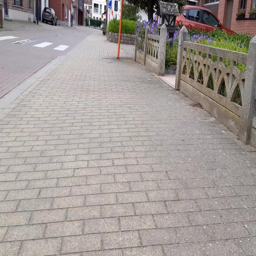

In [ ]:
# OPTIONAL: check one image from data set
dataset["pixel_values"][0].resize([256,256])

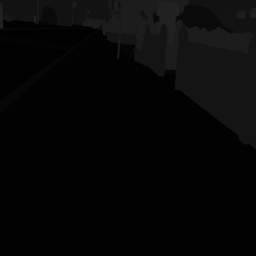

In [ ]:
# OPTIONAL: check one label from data set
dataset["label"][0].resize([256,256])

**Notes about PIL mode**

Normally, images are RGB, which means they have 3 channels, one for red, one for green and one for blue. That normally means that each pixel takes 3 bytes of storage, one for red, one for green and one for blue.

- If you have a P mode image, that means it is palettised. That means there is a palette with up to 256 different colours in it, and instead of storing 3 bytes for R, G and B for each pixel, you store 1 byte which is the index into the palette. This confers both advantages and disadvantages. The advantage is that your image requires 1/3 of the space in memory and on disk. The disadvantage is that it can only represent 256 unique colours - so you may get banding or artefacts.

- If you have an L mode image, that means it is a single channel image - normally interpreted as greyscale. The L means that is just stores the Luminance. It is very compact, but only stores a greyscale, not colour.


In [ ]:
# OPTIONAL: check PIL mode one image from data set
dataset["pixel_values"][0].mode

'RGB'

In [ ]:
# OPTIONAL: check PIL mode one label from data set
dataset["label"][0].mode

'L'

### GPU

In [ ]:
# select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Dataset and Dataloader

[How to convert datasets.arrow_dataset.Dataset to torch.utils.data.Dataset](https://github.com/huggingface/datasets/issues/2165)

Important note about how to transform PIL images to pytorch tensors. It is not the same transform .pgn to tensors to PIL to tensors.

[Converting an image to a Torch Tensor in Python](https://www.geeksforgeeks.org/converting-an-image-to-a-torch-tensor-in-python/)


### Data set class

In [ ]:
from torch.utils.data import Dataset
 
class HFDataset(Dataset):
  def __init__(self, dataset, masks = None, img_transforms = None, mask_transforms = None):
    self.images = dataset["pixel_values"]
    self.masks = dataset["label"]

    self.img_transforms = img_transforms
    self.mask_transforms = mask_transforms

  def __getitem__(self, idx):
    trans = T.PILToTensor()
    resize = T.Resize([128, 128])
    
    img = self.images[idx]
    if self.img_transforms is not None:
      img = self.img_transforms(img)
    else:
      img = trans(img)
    
    if self.masks is not None:
      mask = self.masks[idx]
      if self.mask_transforms is not None:
        mask = resize(mask)
        mask = trans(mask).float()
      else:
        mask = trans(mask)
      
      #mask_max = mask.max().item()
      #mask_max = 34.0 # normalize compares with max number of classes
      #mask /= mask_max
    else:
      return img
      
    return img, mask

  def __len__(self):
    if self.images: 
      assert len(self.images) == len(self.masks), 'Not the same number of images and masks!'
    return len(self.images)



**Error due to single channel image** 



Matplotlib can plot single-channel images. From the documentation of imshow, the input X is:

    X : array-like or PIL image The image data. Supported array shapes are:

        (M, N): an image with scalar data. The data is visualized using a colormap.

        (M, N, 3): an image with RGB values (0-1 float or 0-255 int).

        (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.

    The first two dimensions (M, N) define the rows and columns of the image.

    Out-of-range RGB(A) values are clipped.

So, your data3 is assumed to be an RGB image, data4 an RGBA image, data a single channel image, whereas the data1 has incorrect dimensions for the imshow() (use data1.squeeze(axis=2) instead).


[matplotlib can't plot single channel or greyscale image pixels](https://stackoverflow.com/questions/59601024/matplotlib-cant-plot-single-channel-or-greyscale-image-pixels)

### Transformations


In [ ]:
transform_data = T.Compose([T.Resize([128, 128]),
                            T.ToTensor()
                            ])

### Data loaders

In [ ]:
full_dataset = HFDataset(dataset = dataset, 
                         img_transforms=transform_data,
                         mask_transforms=transform_data
                        )

In [ ]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

print(TRAIN_SIZE, VAL_SIZE)


400 100


In [ ]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [ ]:
print(len(train_dataset), len(val_dataset))

400 100


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    break

0 torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])


### Checking data samples and labels



To improve visualization, we are goint to use another color scale different from gray scale. This is ´viridis´, and for zero values the color will be yellow and for one values the color will be purple. 

By default, the color scale of imshow is ´viridis´. [see doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

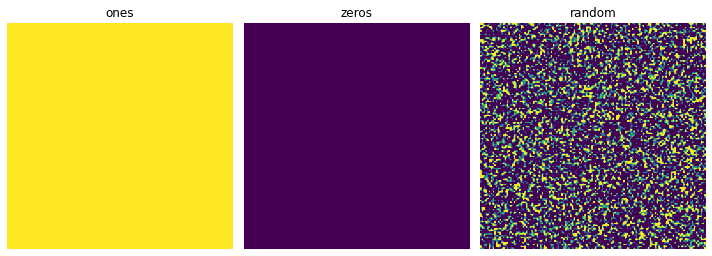

In [ ]:
# show new color scale
plt.figure(figsize=(10,5))

plt.subplot(1, 3, 1)
plt.title("ones")
plt.imshow(torch.ones(128,128), cmap='viridis', vmin=0, vmax=1)
plt.axis('Off')

plt.subplot(1, 3, 2)
plt.title("zeros")
plt.imshow(torch.zeros(128,128), cmap='viridis', vmin=0, vmax=1)
plt.axis('Off')

plt.subplot(1, 3, 3)
plt.title("random")
plt.imshow(torch.randn(128,128), cmap='viridis', vmin=0, vmax=1)
plt.axis('Off')

plt.tight_layout()

In [ ]:
# load a batch to check images and labels 
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])


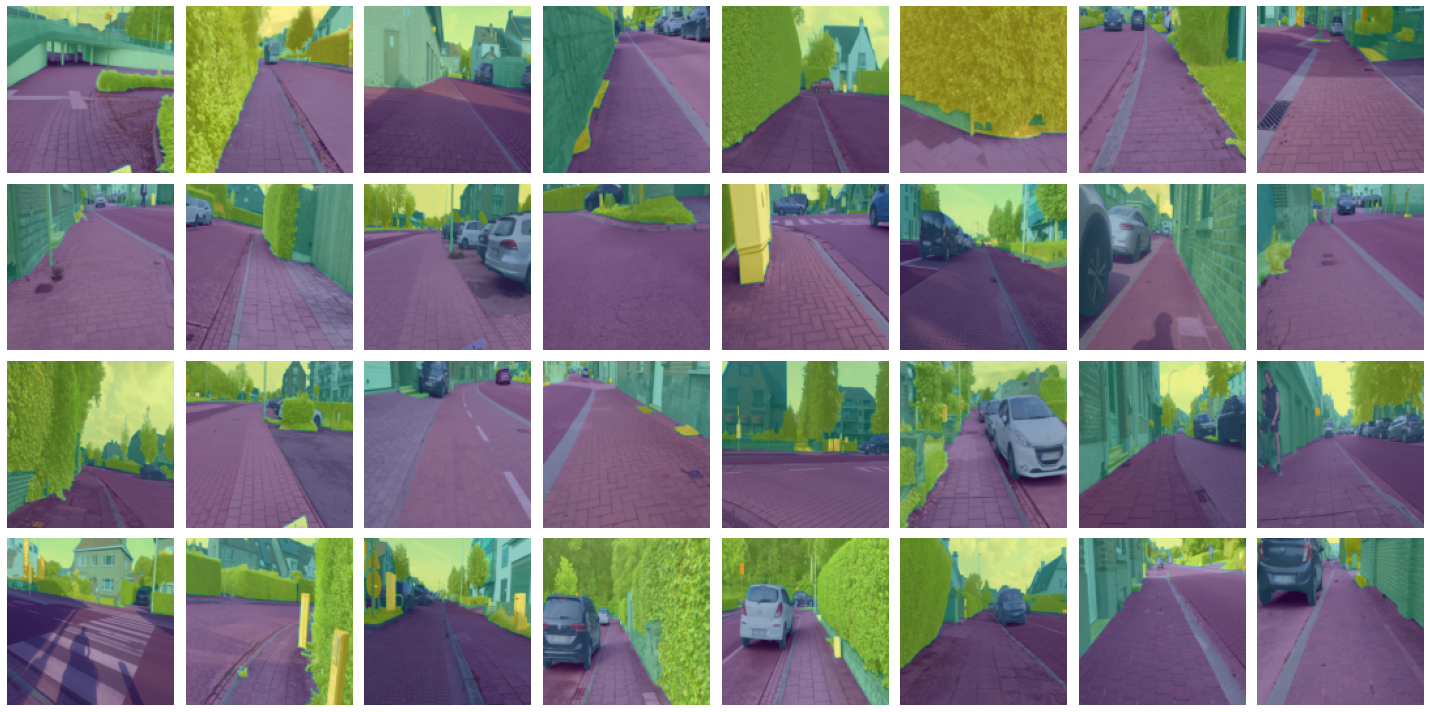

In [ ]:
def plot_mini_batch(imgs, masks):
  plt.figure(figsize=(20,10))
  for i in range(BATCH_SIZE):
    plt.subplot(4, 8, i+1)
    img=imgs[i,...].permute(1,2,0).numpy()
    mask = masks[i, ...].permute(1,2,0).numpy()
    plt.imshow(img)
    # disclaimer so f'ng important: imshow() do not plot single channel images
    plt.imshow(mask.squeeze(axis=2), alpha=0.5, cmap='viridis', vmin=0, vmax=mask.max())
      
    plt.axis('Off')
  plt.tight_layout()
  plt.show()

plot_mini_batch(imgs, masks)

In [ ]:
masks[1,...]

tensor([[[28., 28., 28.,  ..., 18., 18., 18.],
         [28., 28., 28.,  ..., 18., 18., 18.],
         [28., 28., 28.,  ..., 18., 18., 18.],
         ...,
         [28., 28., 28.,  ...,  1.,  1.,  1.],
         [28., 28., 28.,  ...,  1.,  1.,  1.],
         [28., 28., 28.,  ...,  1.,  1.,  1.]]])

In [ ]:
imgs[1,...]

tensor([[[0.3725, 0.2824, 0.3294,  ..., 0.8510, 0.6353, 0.5882],
         [0.2549, 0.2863, 0.2980,  ..., 0.8627, 0.7882, 0.7686],
         [0.2275, 0.2902, 0.2980,  ..., 0.8627, 0.8784, 0.8706],
         ...,
         [0.3725, 0.4039, 0.3373,  ..., 0.7922, 0.7922, 0.7804],
         [0.5451, 0.5490, 0.4941,  ..., 0.7647, 0.7843, 0.7725],
         [0.5686, 0.5608, 0.4275,  ..., 0.7804, 0.7725, 0.7725]],

        [[0.4196, 0.3373, 0.3843,  ..., 0.8392, 0.6196, 0.5765],
         [0.3020, 0.3412, 0.3569,  ..., 0.8510, 0.7725, 0.7569],
         [0.2745, 0.3451, 0.3686,  ..., 0.8510, 0.8627, 0.8588],
         ...,
         [0.4863, 0.5294, 0.4902,  ..., 0.7843, 0.7725, 0.7647],
         [0.6706, 0.6902, 0.6392,  ..., 0.7569, 0.7686, 0.7569],
         [0.6941, 0.6941, 0.5647,  ..., 0.7765, 0.7647, 0.7569]],

        [[0.3216, 0.2078, 0.2549,  ..., 0.7725, 0.5725, 0.5216],
         [0.2039, 0.2078, 0.2118,  ..., 0.7843, 0.7255, 0.7020],
         [0.1765, 0.2118, 0.1843,  ..., 0.7843, 0.8118, 0.

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [ ]:
class Double_Conv(nn.Module):
  '''
  Double convolution block for U-Net
  '''
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.double_conv = nn.Sequential(
                        Conv_3_k(channels_in, channels_out),
                        nn.BatchNorm2d(channels_out),
                        nn.ReLU(),
        
                        Conv_3_k(channels_out, channels_out),
                        nn.BatchNorm2d(channels_out),
                        nn.ReLU(),
                        )
  def forward(self, x):
    return self.double_conv(x)


class Down_Conv(nn.Module):
  '''
  Down convolution part
  '''
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.encoder = nn.Sequential(
                    nn.MaxPool2d(2,2),
                    Double_Conv(channels_in, channels_out)
                    )
  def forward(self, x):
    return self.encoder(x)

class Up_Conv(nn.Module):
  '''
  Up convolution part
  '''
  def __init__(self,channels_in, channels_out):
    super().__init__()
    self.upsample_layer = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='bicubic'),
                    nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                    )
    self.decoder = Double_Conv(channels_in, channels_out)

  def forward(self, x1, x2):
    '''
    x1 - upsampled volume
    x2 - volume from down sample to concatenate
    '''
    x1 = self.upsample_layer(x1)
    x = torch.cat([x2, x1],dim=1)
    return self.decoder(x)

class UNET(nn.Module):
  '''
  UNET model
  '''
  def __init__(self, channels_in, channels, num_classes):
    super().__init__()
    self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
    self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
    self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
    self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
    
    self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
    
    self.up_conv1 = Up_Conv(16*channels, 8*channels)
    self.up_conv2 = Up_Conv(8*channels, 4*channels)
    self.up_conv3 = Up_Conv(4*channels, 2*channels)
    self.up_conv4 = Up_Conv(2*channels, channels)
    
    self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
  def forward(self, x):
    x1 = self.first_conv(x)
    x2 = self.down_conv1(x1)
    x3 = self.down_conv2(x2)
    x4 = self.down_conv3(x3)
    
    x5 = self.middle_conv(x4)
    
    u1 = self.up_conv1(x5, x4)
    u2 = self.up_conv2(u1, x3)
    u3 = self.up_conv3(u2, x2)
    u4 = self.up_conv4(u3, x1)
    
    return self.last_conv(u4)

### Plot some images and predictions doing by the model

torch.Size([32, 128, 128])


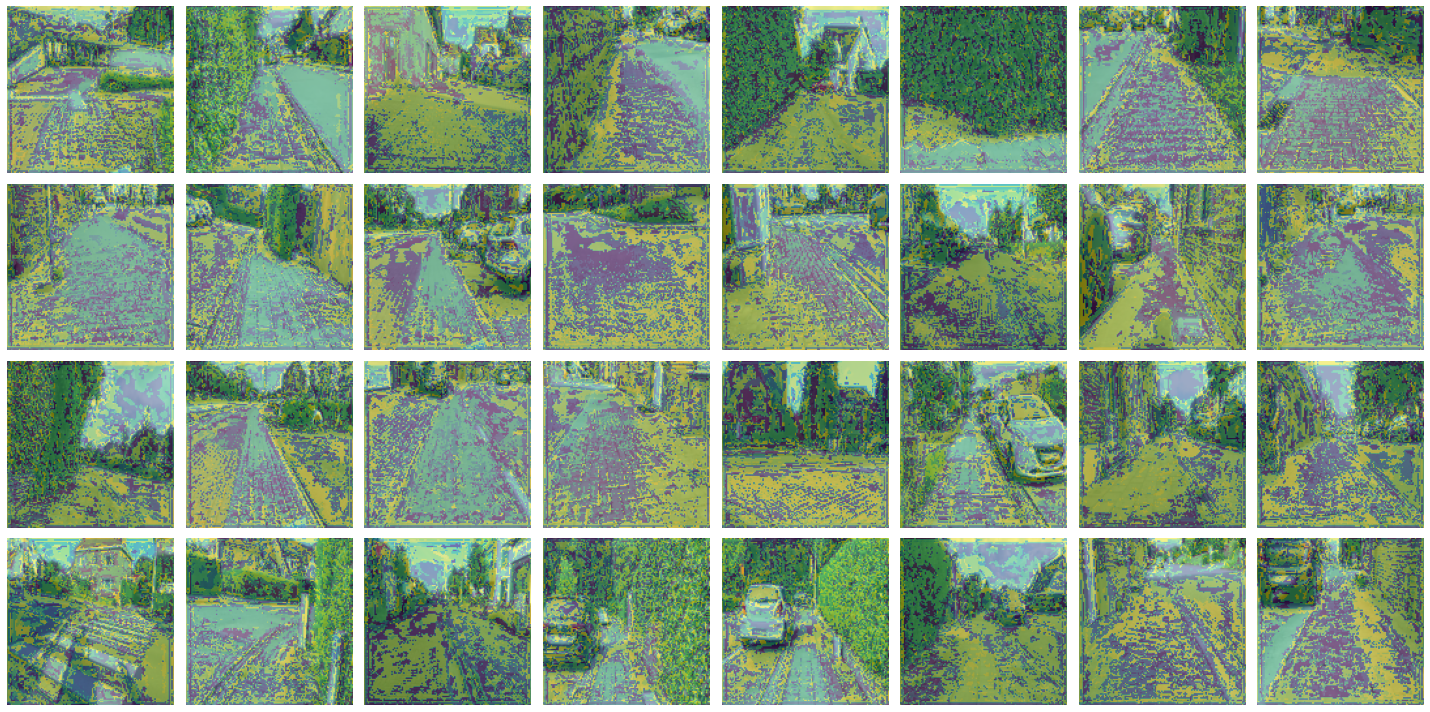

In [ ]:
model = UNET(3, 64, 35)

imgs = imgs.to(device, dtype=torch.float32)
masks = masks.to(device, dtype=torch.float32)
model = model.to(device)

with torch.no_grad():
    scores = model(imgs)
    preds = torch.argmax(scores, dim=1).float()

imgs = imgs.cpu()
masks = masks.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs, preds.unsqueeze(1))

In [ ]:
F.cross_entropy(input=preds, target=masks.squeeze(1))

tensor(21139.0488)

In [ ]:
preds.min(), preds[1,...].max(), 

(tensor(0.), tensor(34.))

In [ ]:
masks.min(), masks.max(), 

(tensor(0.), tensor(34.))

## Train model

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 32):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
#            if scheduler: 
 #               scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
                    # Save data
                    #train_acc_history.append(train_acc)
                    #train_cost_history.append(train_cost_every)
        #train_acc = float(train_correct_num)/train_total
        #train_cost_every = float(train_cost_acum)/len(train_loader)
        # return train_acc_history ... etc    

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    intersection = 0
    union = 0
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1).float()
        #union += (preds + y - preds*y).sum()
        #acc_ = (intersection)/(union + 1e-8)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies    

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [ ]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 64, 35)
#optimiser_unet = torch.optim.SGD(model.parameters(),
 #                                lr=0.001, momentum=0.95,
  #                               weight_decay=1e-8)
LEARNING_RATE = 0.0005
optimiser_unet = optim.Adam(model.parameters(), lr=LEARNING_RATE)


lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:3.6512, lr: 0.0000, acc: 0.0008
cost:3.6814, lr: 0.0000, acc: 0.0007
cost:3.6380, lr: 0.0000, acc: 0.0007
cost:3.6127, lr: 0.0001, acc: 0.0010
cost:3.5213, lr: 0.0002, acc: 0.0017
cost:3.3538, lr: 0.0008, acc: 0.0043
cost:3.1190, lr: 0.0032, acc: 0.0107
cost:3.0269, lr: 0.0121, acc: 0.0109
cost:2.9445, lr: 0.0464, acc: 0.0082
cost:2.2445, lr: 0.1778, acc: 0.0124
cost:3.0768, lr: 0.6813, acc: 0.0115
cost:5.1925, lr: 2.6102, acc: 0.0071
cost:5.0549, lr: 10.0000, acc: 0.0070


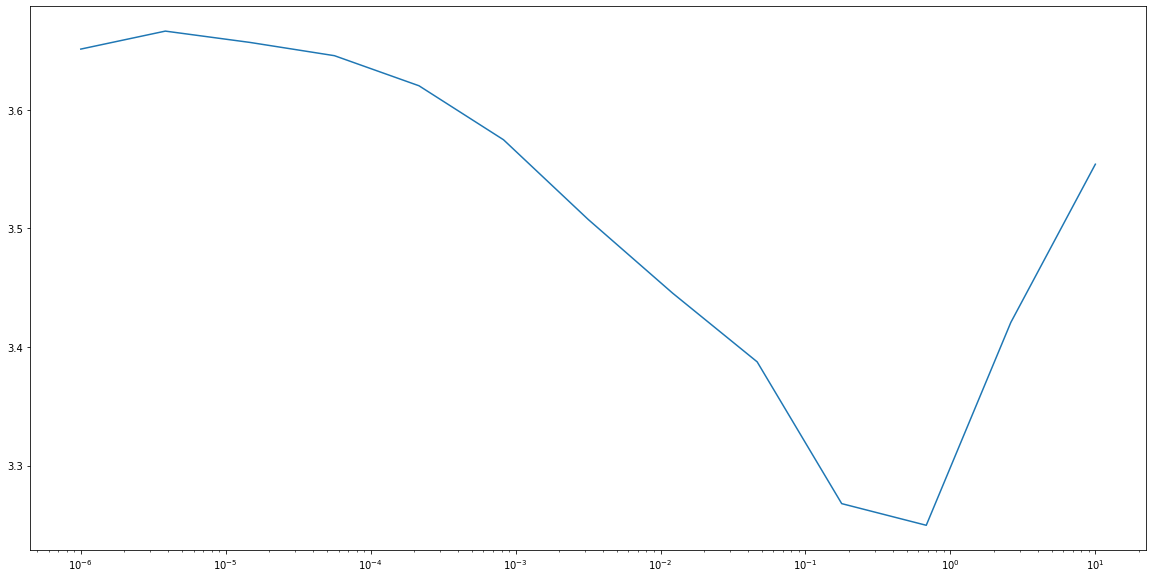

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()



In [ ]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 64, 35)
epochs = 2
#optimiser_unet = torch.optim.SGD(model.parameters(),
 #                                lr=0.01, momentum=0.95,
  #                               weight_decay=1e-8)
LEARNING_RATE = 0.0005
optimiser_unet = optim.Adam(model.parameters(), lr=LEARNING_RATE)



scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 0.1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
# train(model, optimiser_unet, scheduler, epochs)
cost_ce = nn.CrossEntropyLoss()
train(model, optimiser_unet, epochs)

torch.Size([32, 128, 128])


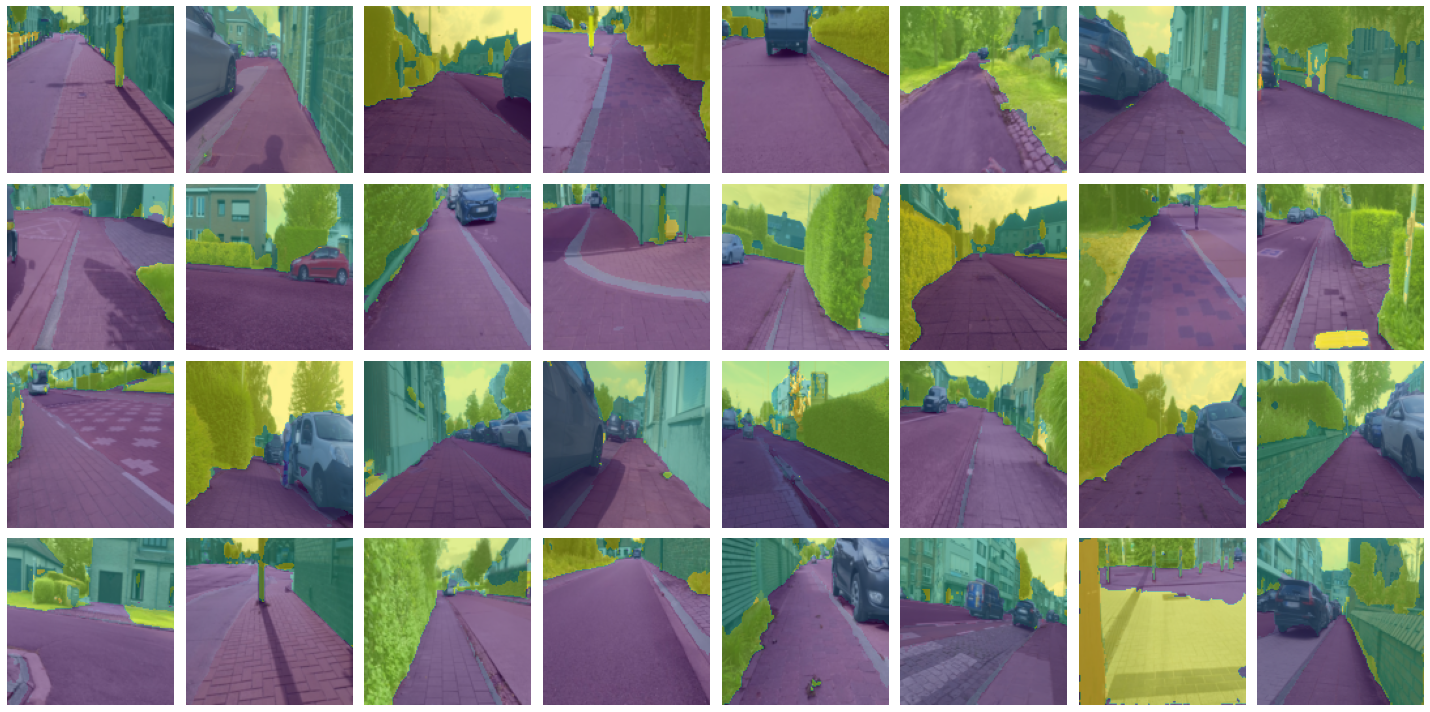

In [ ]:
imgs_train, masks_train = next(iter(train_loader))
imgs_train = imgs_train.to(device, dtype=torch.float32)
model = model.to(device)

with torch.no_grad():
    scores = model(imgs_train)
    preds = torch.argmax(scores, dim=1)

imgs_train = imgs_train.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_train, preds.unsqueeze(1))

In [ ]:
def plot_mini_batch_lab(masks):
  plt.figure(figsize=(20,10))
  for i in range(BATCH_SIZE):
    plt.subplot(4, 8, i+1)
    img=imgs[i,...].permute(1,2,0).numpy()
    mask = masks[i, ...].permute(1,2,0).numpy()
    #plt.imshow(img)
    # disclaimer so f'ng important: imshow() do not plot single channel images
    plt.imshow(mask.squeeze(axis=2), alpha=0.5, cmap='viridis', vmin=0, vmax=mask.max())
      
    plt.axis('Off')
  plt.tight_layout()
  plt.show()


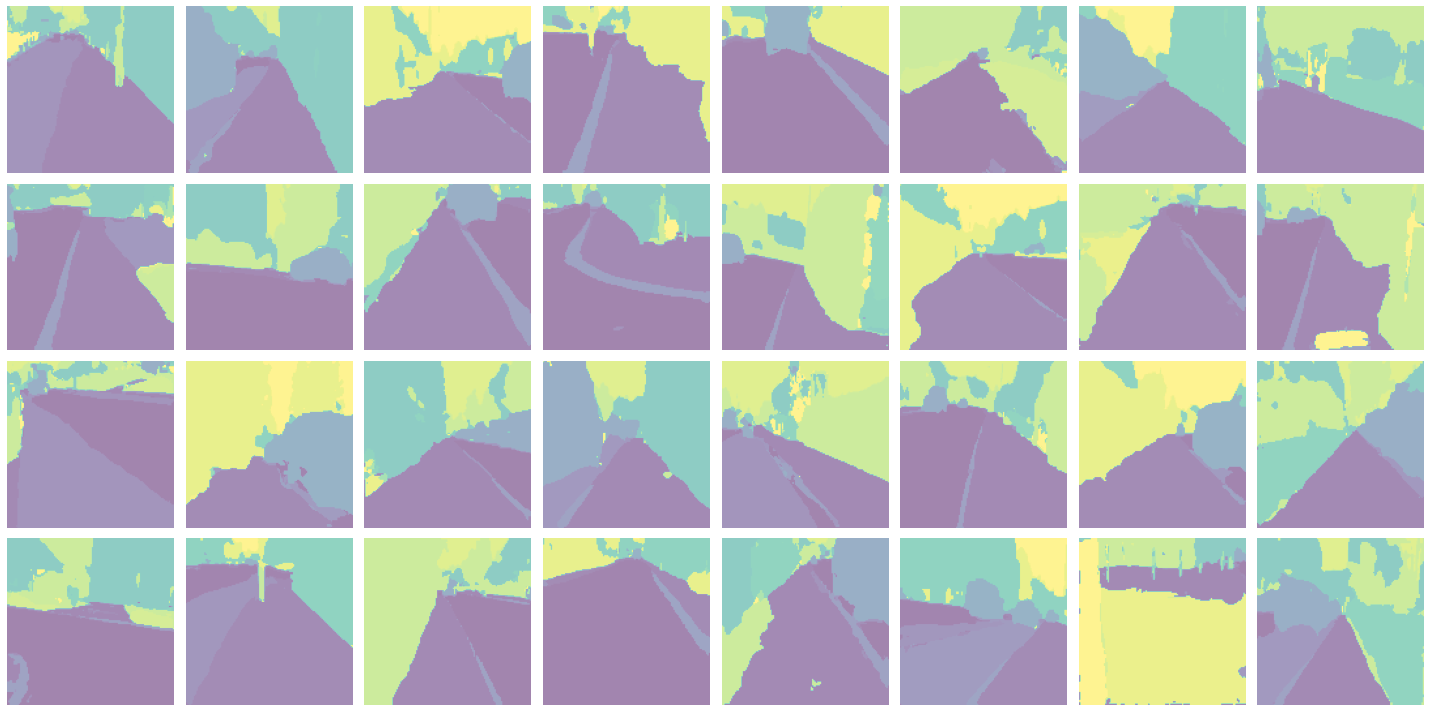

In [ ]:
plot_mini_batch_lab(preds.unsqueeze(1))

torch.Size([32, 128, 128])


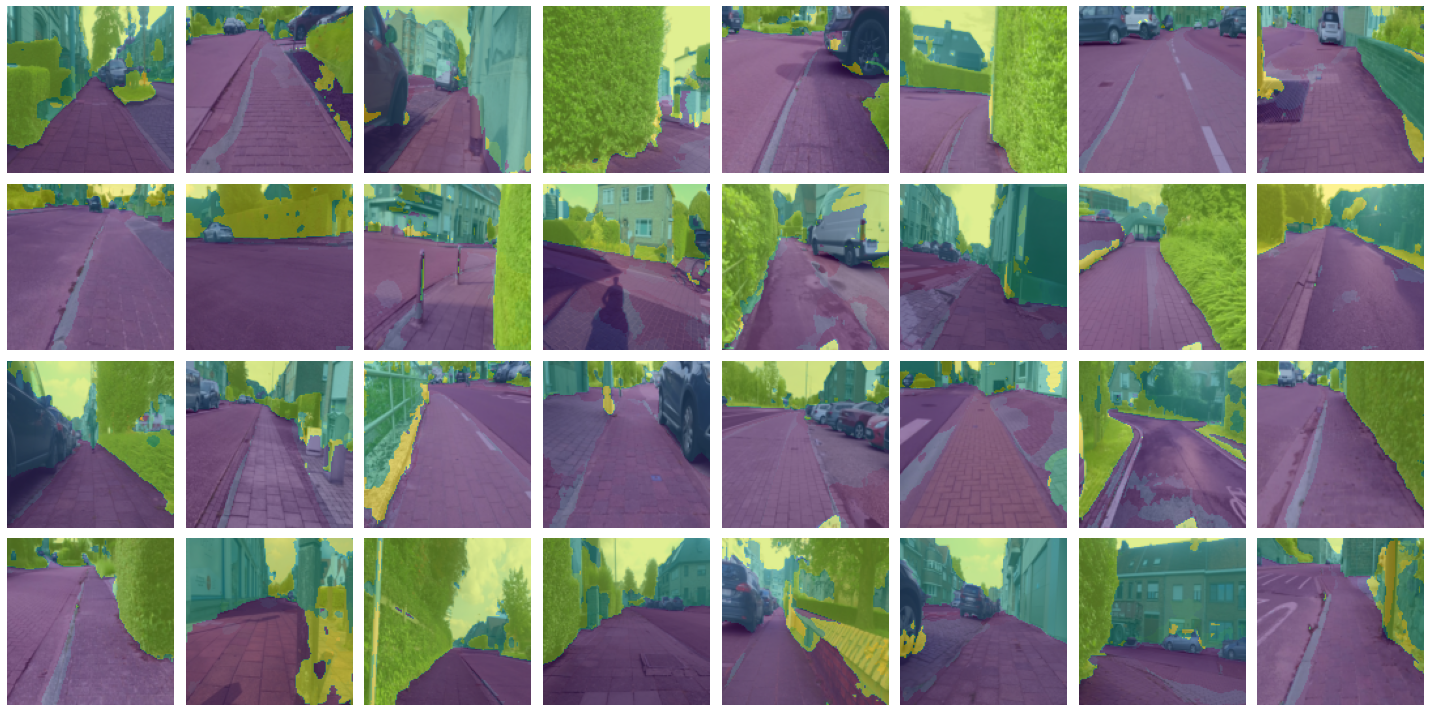

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
#model = model.to(device)

with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1)

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

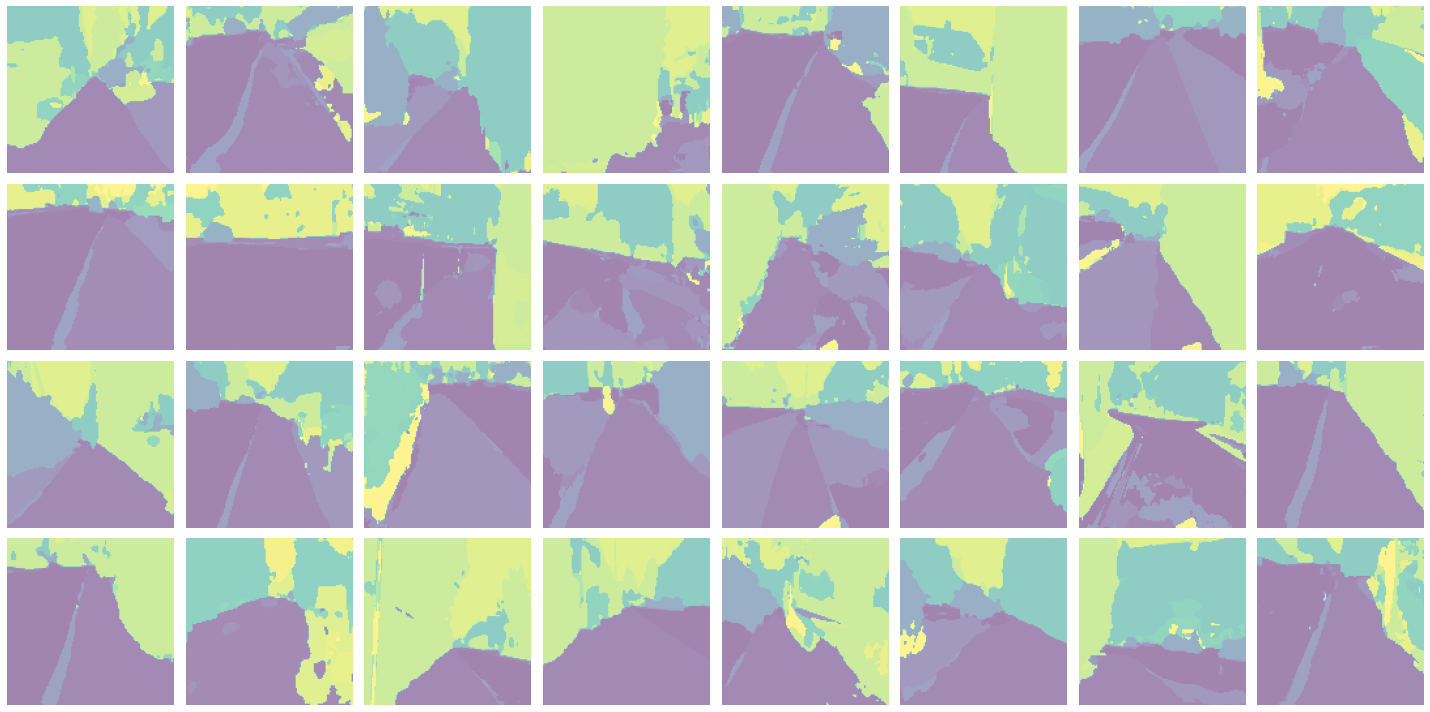

In [ ]:
plot_mini_batch_lab(preds.unsqueeze(1))

In [ ]:
cost, accu, dice, iou  = accuracy(model, val_loader)
print(cost, accu, dice, iou)

1.452258974313736 0.723245849609375 tensor(21.0656, device='cuda:0') tensor(-1.1049, device='cuda:0')
